In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors, QED

In [16]:
df = pd.read_csv('BindingDB_All.tsv', sep='\t', on_bad_lines='skip')
df.shape

/var/folders/9z/jvyz2w6d2v1bbg_kkfnms6m00000gn/T/ipykernel_93926/1051280969.py:1: DtypeWarning: Columns (8,9,10,11,12,13,15,17,20,21,22,23,27,28,32,33,35,36,45,46,47,48,50,51,52,53,54,55,57,58,59,60,62,63,64,65,66,67,69,70,71,72,74,75,76,77,78,79,81,82,83,86,87,88,89,90,91,93,94,95,98,99,100,101,102,103,105,106,107,110,111,112,113,114,115,117,118,119,122,123,124,125,126,127,129,130,131,134,135,136,137,138,139,146,147,148,149,150,151,158,159,160,161,162,163,170,172,173,174,175) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('BindingDB_All.tsv', sep='\t', on_bad_lines='skip')


(2913040, 194)

In [18]:
likable_drugs = df.loc[:, ['BindingDB Reactant_set_id', 'Ligand SMILES', 'BindingDB Ligand Name', 'Target Name']]

likable_drugs.head()

,BindingDB Reactant_set_id,Ligand SMILES,BindingDB Ligand Name,Target Name
0,1,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CCCCCC(O)=...,"6-[(4R,5S,6S,7R)-4,7-dibenzyl-3-(5-carboxypent...",Dimer of Gag-Pol polyprotein [501-599]
1,2,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(C\C=C\c2cn...,"(4R,5S,6S,7R)-4,7-dibenzyl-5,6-dihydroxy-1,3-b...",Dimer of Gag-Pol polyprotein [501-599]
2,3,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CC2CC2)C(=...,"(4R,5S,6S,7R)-4,7-dibenzyl-1-(cyclopropylmethy...",Dimer of Gag-Pol polyprotein [501-599]
3,4,OCCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@...,"(4R,5S,6S,7R)-4,7-dibenzyl-1-(cyclopropylmethy...",Dimer of Gag-Pol polyprotein [501-599]
4,5,OCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@H...,"(4R,5S,6S,7R)-4,7-dibenzyl-1-(cyclopropylmethy...",Dimer of Gag-Pol polyprotein [501-599]


To evaluate whether the drug is 'likable' or not we will use three main criteria: Lipinski's Rule of Five, QED score and Verber criteria. 

##### **Lipinski's Rule of Five** 

Lipinski's Rule is a set of guidelines for assessing the potential oral bioavailability of a molecule based on its physicochemical properties According to these rules, a molecule is considered drug-like if it meets the following criteria:

- Molecular weight (MW) < 500 g/mol
- Log P (octanol-water partition coefficient) < 5
- Number of hydrogen bond donors ≤ 5
- Number of hydrogen bond acceptors ≤ 10

##### **Quantitative Estimate of Drug-likeness (QED)**

The QED score is a quantitative measure of drug-likeness that combines multiple physicochemical properties into a single score ranging from 0 to 1. Higher QED scores indicate greater drug-likeness. The properties considered in QED include:

- Molecular weight (MW)
- Log P (octanol-water partition coefficient)
- Number of hydrogen bond donors
- Number of hydrogen bond acceptors
- Rotatable bonds
- Polar surface area (PSA)

##### **Veber Criteria**

Veber's Rule is another guideline for evaluating the oral bioavailability of molecules, emphasizing flexibility and surface area. According to Veber criteria, a molecule is considered drug-like if it meets the following conditions:

- Rotatable bonds: ≤ 10
- Polar Surface Area (PSA): ≤ 140 Å²

In [58]:
def calculate_drug_properties(df, smiles_column='Ligand SMILES'):
    """
    Calculates drug-likeness properties for each compound in the dataset.
    
    Parameters:
    df (DataFrame): DataFrame containing the compounds with SMILES strings.
    smiles_column (str): The column name that contains the SMILES strings.

    Returns:
    DataFrame: Original DataFrame with additional columns for each drug-likeness property.
    """
    
    molecular_weights = []
    log_p_values = []
    h_donors = []
    h_acceptors = []
    rotatable_bonds = []
    psa_values = []
    qed_scores = []
    lipinski_pass = []
    veber_pass = []

    for smiles in df[smiles_column]:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            molecular_weights.append(None)
            log_p_values.append(None)
            h_donors.append(None)
            h_acceptors.append(None)
            rotatable_bonds.append(None)
            psa_values.append(None)
            qed_scores.append(None)
            lipinski_pass.append(False)
            veber_pass.append(False)
        else:
            molecular_weights.append(Descriptors.MolWt(mol))
            log_p_values.append(Descriptors.MolLogP(mol))
            h_donors.append(Descriptors.NumHDonors(mol))
            h_acceptors.append(Descriptors.NumHAcceptors(mol))
            rotatable_bonds.append(Descriptors.NumRotatableBonds(mol))
            psa_values.append(Descriptors.TPSA(mol))
            qed_scores.append(QED.qed(mol))
            
            # Check Lipinski's Rule of Five
            lipinski_pass.append(
                molecular_weights[-1] < 500 and
                log_p_values[-1] < 5 and
                h_donors[-1] <= 5 and
                h_acceptors[-1] <= 10
            )
            
            # Check Veber's Rule
            veber_pass.append(
                rotatable_bonds[-1] <= 10 and psa_values[-1] <= 140
            )

    df['Molecular Weight'] = molecular_weights
    df['Log P'] = log_p_values
    df['H Donors'] = h_donors
    df['H Acceptors'] = h_acceptors
    df['Rotatable Bonds'] = rotatable_bonds
    df['PSA'] = psa_values
    df['QED Score'] = qed_scores
    df['Lipinski Pass'] = lipinski_pass
    df['Veber Pass'] = veber_pass

    return df

In [ ]:
likable_drugs = calculate_drug_properties(likable_drugs)
likable_drugs.head()

In [23]:
likable_drugs.to_csv('likable_drugs_dataset.csv')

In [47]:
likable_drugs.isna().sum()

BindingDB Reactant_set_id       0
Ligand SMILES                   0
BindingDB Ligand Name           0
Target Name                     0
Molecular Weight             3038
Log P                        3038
H Donors                     3038
H Acceptors                  3038
Rotatable Bonds              3038
PSA                          3038
QED Score                    3038
Lipinski Pass                   0
Veber Pass                      0
dtype: int64

In [48]:
nan_qed_smiles = likable_drugs[likable_drugs["QED Score"].isna()]["Ligand SMILES"]

print("SMILES strings with NaN QED Score:")
print(nan_qed_smiles)

SMILES strings with NaN QED Score:
14035      CN[C@@H](C)C(=O)N[C@H]1CN(CC[C@H]2CC[C@H](N2C1...
14160      CN[C@@H](C)C(=O)N[C@H]1CN(CC[C@H]2CC[C@H](N2C1...
15810      CC(C)(C)OC(=O)N1CC(=O)N(C(=O)C1)c1ccc(cc1)N1CC...
36001      CSc1ccc(cc1)C1=C(C=C[N]([O-])=C1)[C@@H]1CCC(F)...
36012      CSc1ccc(cc1)C1=C(C=C[N]([O-])=C1)[C@@H]1CCC(F)...
                                 ...                        
1629667    Oc1ccc(cc1)[B]1234[B]567[B]89%10[B]%11%12%13[B...
1629668    Oc1ccc(cc1)[C]1234[B]567[B]89%10[B]55%11[B]88%...
1629669    Oc1ccc(cc1)[C]1234[B]567[B]89%10[B]%11%12%13[B...
2369979    CC(C)C[C@H](NC(=O)[C@H](CC[C]1234B5B6B5[B--]11...
2792092    Clc1ccc(cc1)S(=O)(=O)c1ccc(NC(=O)NCC2=CN[H]=C2...
Name: Ligand SMILES, Length: 3038, dtype: object


We have identified over 3000 NaN QED scores in our dataset. A potential reason for this could be the presence of invalid SMILES strings, which may also be causing issues in extracting drug properties for these observations. Let’s investigate this further.

In [49]:
def check_smiles_validity(smiles_list):
    """
    Checks the validity of a list of SMILES strings.

    Parameters:
    smiles_list (list): List of SMILES strings.

    Returns:
    DataFrame: DataFrame with SMILES strings and their validity.
    """
    results = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            results.append({"SMILES": smiles, "Valid": False})
        else:
            results.append({"SMILES": smiles, "Valid": True})
    return pd.DataFrame(results)

validity_df = check_smiles_validity(nan_qed_smiles)

print(validity_df)

[18:07:11] non-ring atom 28 marked aromatic
[18:07:11] non-ring atom 28 marked aromatic
[18:07:11] Explicit valence for atom # 28 N, 4, is greater than permitted
[18:07:11] Explicit valence for atom # 12 N, 4, is greater than permitted
[18:07:11] Explicit valence for atom # 12 N, 4, is greater than permitted
[18:07:11] Explicit valence for atom # 17 O, 3, is greater than permitted
[18:07:11] Explicit valence for atom # 16 O, 3, is greater than permitted
[18:07:11] Explicit valence for atom # 16 O, 3, is greater than permitted
[18:07:11] Explicit valence for atom # 17 O, 3, is greater than permitted
[18:07:11] Explicit valence for atom # 16 O, 3, is greater than permitted
[18:07:11] Explicit valence for atom # 16 O, 3, is greater than permitted
[18:07:11] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 15 16
[18:07:11] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 14 15 16
[18:07:11] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 15 16
[18:07:11] Can't kekulize mol.  

                                                 SMILES  Valid
0     CN[C@@H](C)C(=O)N[C@H]1CN(CC[C@H]2CC[C@H](N2C1...  False
1     CN[C@@H](C)C(=O)N[C@H]1CN(CC[C@H]2CC[C@H](N2C1...  False
2     CC(C)(C)OC(=O)N1CC(=O)N(C(=O)C1)c1ccc(cc1)N1CC...  False
3     CSc1ccc(cc1)C1=C(C=C[N]([O-])=C1)[C@@H]1CCC(F)...  False
4     CSc1ccc(cc1)C1=C(C=C[N]([O-])=C1)[C@@H]1CCC(F)...  False
...                                                 ...    ...
3033  Oc1ccc(cc1)[B]1234[B]567[B]89%10[B]%11%12%13[B...  False
3034  Oc1ccc(cc1)[C]1234[B]567[B]89%10[B]55%11[B]88%...  False
3035  Oc1ccc(cc1)[C]1234[B]567[B]89%10[B]%11%12%13[B...  False
3036  CC(C)C[C@H](NC(=O)[C@H](CC[C]1234B5B6B5[B--]11...  False
3037  Clc1ccc(cc1)S(=O)(=O)c1ccc(NC(=O)NCC2=CN[H]=C2...  False

[3038 rows x 2 columns]


Our hypothesis was confirmed, and we identified invalid SMILES as the cause. Therefore, we will exclude these invalid SMILES from further analysis.

In [50]:
likable_drugs.dropna(inplace=True)
likable_drugs.isna().sum()

BindingDB Reactant_set_id    0
Ligand SMILES                0
BindingDB Ligand Name        0
Target Name                  0
Molecular Weight             0
Log P                        0
H Donors                     0
H Acceptors                  0
Rotatable Bonds              0
PSA                          0
QED Score                    0
Lipinski Pass                0
Veber Pass                   0
dtype: int64

In [55]:
qed_values = likable_drugs.dropna(subset="QED Score")["QED Score"].values
q75, q90, q95 = np.percentile(qed_values, [75, 90, 95])

In [ ]:
count_q75 = len(likable_drugs[(likable_drugs["Lipinski Pass"] == True) & 
                              (likable_drugs["Veber Pass"] == True) & 
                              (likable_drugs["QED Score"] >= q75)])

count_q90 = len(likable_drugs[(likable_drugs["Lipinski Pass"] == True) & 
                              (likable_drugs["Veber Pass"] == True) & 
                              (likable_drugs["QED Score"] >= q90)])

count_q95 = len(likable_drugs[(likable_drugs["Lipinski Pass"] == True) & 
                              (likable_drugs["Veber Pass"] == True) & 
                              (likable_drugs["QED Score"] >= q95)])

print(f"Number of observations over 75th percentile: {count_q75} out of {len(qed_values)}")
print(f"Number of observations over 90th percentile: {count_q90} out of {len(qed_values)}")
print(f"Number of observations over 95th percentile: {count_q95} out of {len(qed_values)}")

Number of observations over 75th percentile: 711735 out of 2910002
Number of observations over 90th percentile: 289274 out of 2910002
Number of observations over 95th percentile: 145396 out of 2910002


In [66]:
q75,q90,q95

(0.6683053742047123, 0.7845689111651782, 0.8422909732042051)

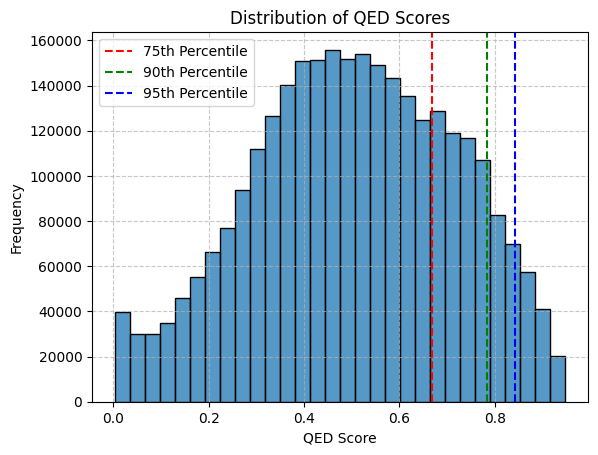

In [65]:
sns.histplot(qed_values, bins=30)
plt.axvline(q75, color='red', linestyle='--', label='75th Percentile')
plt.axvline(q90, color='green', linestyle='--', label='90th Percentile')
plt.axvline(q95, color='blue', linestyle='--', label='95th Percentile')
plt.title("Distribution of QED Scores")
plt.xlabel("QED Score")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

The histogram shows that most compounds have QED scores between 0.4 and 0.8, with a peak around 0.6, indicating moderate drug-likeness for the majority. Only the top 25% have scores above 0.668, the top 10% above 0.785, and the top 5% exceed 0.842. Compounds above 0.7 are generally considered highly drug-like and may be prioritized for further study.

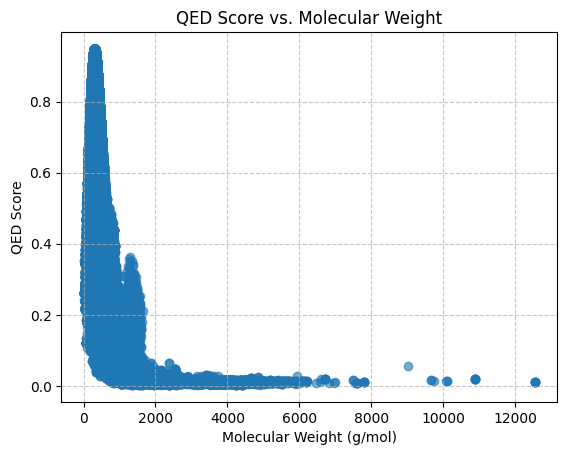

In [64]:
molecular_weights = likable_drugs["Molecular Weight"].values

plt.scatter(molecular_weights, qed_values, alpha=0.6)
plt.title("QED Score vs. Molecular Weight")
plt.xlabel("Molecular Weight (g/mol)")
plt.ylabel("QED Score")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

We observe that compounds with lower molecular weights tend to have higher QED scores, with scores dropping sharply as molecular weight increases. Compounds with molecular weights above 1,000 g/mol generally have very low QED scores, suggesting that higher molecular weight compounds are less drug-like. 

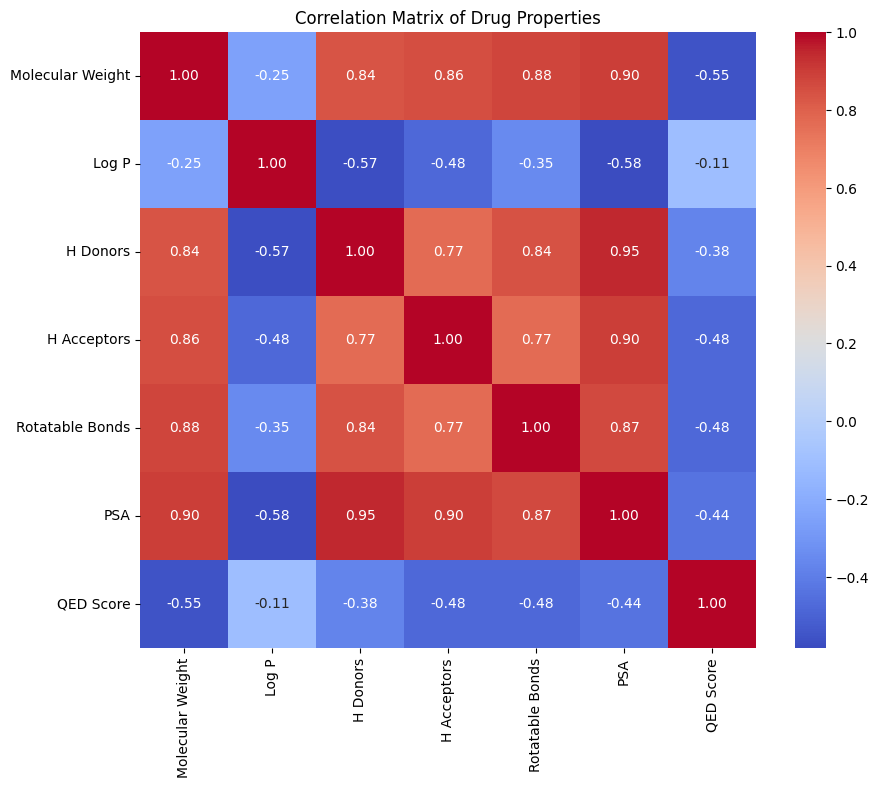

In [70]:
properties = ['Molecular Weight', 'Log P', 'H Donors', 'H Acceptors', 'Rotatable Bonds', 'PSA', 'QED Score']
correlation_matrix = likable_drugs[properties].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix of Drug Properties")
plt.show()

The heatmap shows that larger molecules (higher molecular weight) with more rotatable bonds, hydrogen bond donors, and acceptors tend to have lower QED scores, indicating they are less drug-like. QED scores are negatively correlated with molecular weight and polar surface area (PSA), suggesting that smaller, less polar compounds are generally more favorable for drug-likeness. Additionally, lipophilic compounds (higher Log P) tend to have fewer polar groups and less flexibility.

/Users/alexandra/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


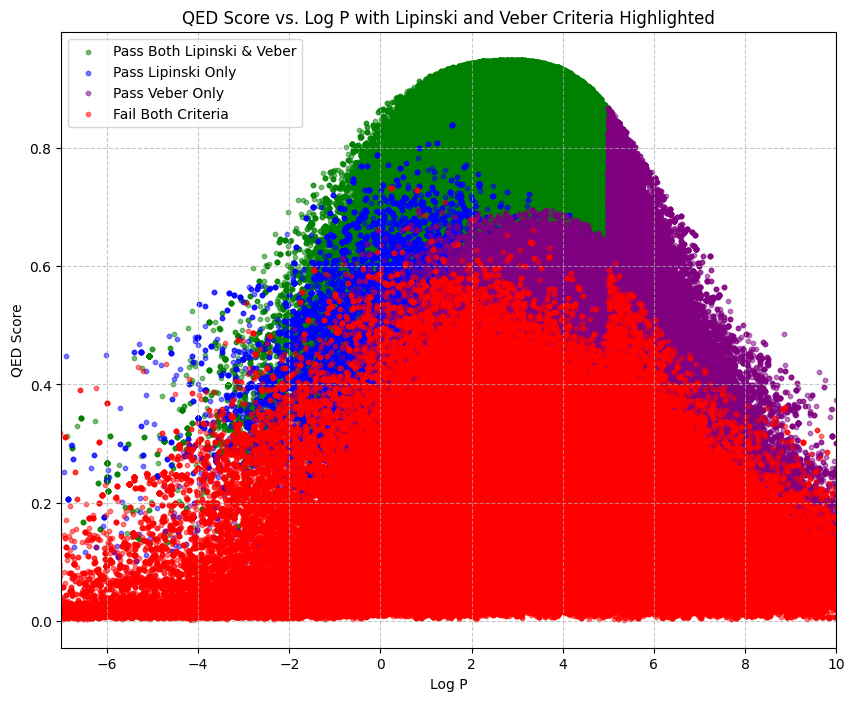

In [75]:
plt.figure(figsize=(10, 8))
for color in ['green', 'blue', 'purple', 'red']:
    subset = likable_drugs[likable_drugs['Color'] == color]
    label = ''
    if color == 'green':
        label = 'Pass Both Lipinski & Veber'
    elif color == 'blue':
        label = 'Pass Lipinski Only'
    elif color == 'purple':
        label = 'Pass Veber Only'
    elif color == 'red':
        label = 'Fail Both Criteria'
    plt.scatter(subset['Log P'], subset['QED Score'], c=color, label=label, alpha=0.5, s=10)

plt.xlim(-7, 10)

plt.xlabel("Log P")
plt.ylabel("QED Score")
plt.title("QED Score vs. Log P with Lipinski and Veber Criteria Highlighted")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

The plot shows that compounds with moderate Log P values (around 0 to 5) tend to have higher QED scores, indicating a balance between lipophilicity and drug-likeness. Compounds that pass both Lipinski and Veber criteria (green points) are clustered in this favorable range, with QED scores often above 0.6, suggesting they are more drug-like. In contrast, compounds that fail both criteria (red points) generally have lower QED scores and are spread across both high and low Log P values. This suggests that extreme lipophilicity or hydrophilicity is less favorable for drug-likeness.